Hunter Bennett | Glass Lab | Kupffer Strains Project | 04 June 2021

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib_venn as venn
import seaborn as sns
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['savefig.dpi'] = 500


# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

# Set working directory

In [2]:
dataDirectory = '/home/h1bennet/strains/data/H3K27Ac/control_f1/'
workingDirectory = '/home/h1bennet/strains_f1/results/00_CB6F1_Control/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# We will start by using O'young's script to get the IDR peaks for each condition
____
We already made these for the QC notebook!  

The output of peakIDR.R includes many things, the main thing we use are the final .idr peak files for each group


# Run peakIDR.R

    source activate r-ouyangPipe
    
    mkdir ./peakQuan/

    mkdir ./peakDiff/

    nohup peakQuan.R ./sampleDef.txt -o ./peakQuan/ -g mm10 -a chip \
    -p ~/strains_f1/data/annotate_mutations_merge_f0_f1.idr \
    --homer='-size 1000 -pc 0' > peakQuan.nohup.out

    nohup peakDiff.R ./sampleDef.txt -o ./peakDiff/ -g mm10 -a atac \
    -q ./peakQuan/allRawTags.txt > peakDiff.nohup.out
    
In a fun turn of events, our allele specific bias calls appear to be quite sensitive to clonality, so we will see whether using -pc 3 can help improve our results

    nohup peakQuan.R ./sampleDef.txt -o ./peakQuan_pc3/ -g mm10 -a chip \
    -p ~/strains_f1/data/annotate_mutations_merge_f0_f1.idr \
    --homer='-size 1000' > peakQuan_pc3.nohup.out


# Make multiwig hub of merged peaks

    makeMultiWigHub.pl hrb_strains_f1_h3k27ac_merged mm10 \
    -color 49,163,84 49,130,189 \
    49,163,84 49,130,189 \
    -force -d \
    /home/h1bennet/strains_f1/results/00_CB6F1_Control/peakQuan/mergeTag/perfect_c57bl6j_control_paths/ \
    /home/h1bennet/strains_f1/results/00_CB6F1_Control/peakQuan/mergeTag/perfect_balbcj_control_paths/ \
    /home/h1bennet/strains_f1/results/00_CB6F1_Control/peakQuan/mergeTag/onlymuts_c57bl6j_paths/ \
    /home/h1bennet/strains_f1/results/00_CB6F1_Control/peakQuan/mergeTag/onlymuts_balbcj_paths/

In [3]:
# %%bash
# # if directories don't exist, create them
# if [ ! -d ./atac_peak_files/ ]; then mkdir ./atac_peak_files; fi
# # move IDR peaks into atac_peak_folder
# mv *kupffer*.idr ./atac_peak_files

### convert to bed files

    mkdir ./atac_bed_files
    pos2bed.pl -o ./atac_bed_files/f0_f1_idr_peaks.bed \
    -track "F0 F1 IDR Peaks Merged" ~/strains_f1/data/annotate_mutations_merge_f0_f1.idr
    
    pos2bed.pl -o ./atac_bed_files/f0_f1_idr_peaks_with_mutation.bed \
    -track "F0 F1 IDR Peaks Mutated C57 to BALB" ~/strains_f1/data/mutations_annotate_mutations_merge_f0_f1.idr

# Summary plots

In [4]:
# make folder for figures
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

### Read in annotation files

In [5]:
# import annotation file
df, mat = read_annotated_peaks('./peakQuan/allNormTags.txt')

# shorten columns to make labeling nicer
mat.columns = mat.columns.str.split('/').str[-1]

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

Lets start by looking at the peak intensity distribution for each sample.

In [6]:
greps = ['tag_perfect.*mm10',
         'tag_perfect.*balbcj',
         'tag_only.*mm10',
         'tag_only.*balbcj']

labels = ['C57BL6J Tag Perfect',
          'BALBcJ Tag Perfect',
          'C57BL6J Mutation Spanning',
          'BALBcJ Mutation Spanning']

colors = ['#31a354',
          '#3182bd',
          '#006d2c',
          '#08519c']

n_bins=20
transparency=0.6

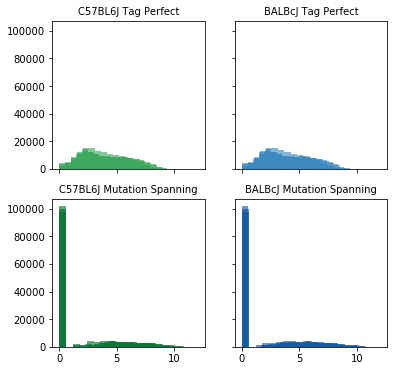

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(6,6),
                        sharex=True,
                        sharey=True)
# plt.subplots_adjust(hspace=0.4, wspace=0.4)

for grep, label, color, ax in zip(greps, labels, colors, axs.flat):
    
    for col in mat.columns[mat.columns.str.contains(grep)]:
        ax.hist(np.log2(mat.loc[:, col]+1),
                bins=n_bins,
                histtype='bar',
                color=color,
                alpha=transparency);
        ax.set_title(label, fontsize=10)

Zeros appear to dominate the above plot so lets try while filtering out peaks with less than 4 tag counts

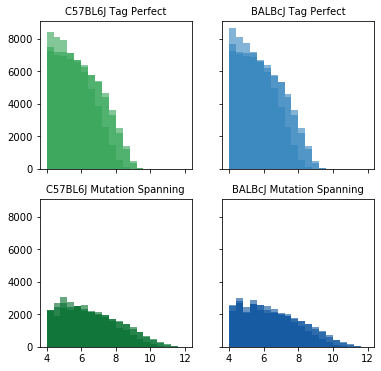

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(6,6),
                        sharex=True,
                        sharey=True)
# plt.subplots_adjust(hspace=0.4, wspace=0.4)

for grep, label, color, ax in zip(greps, labels, colors, axs.flat):
    
    for col in mat.columns[mat.columns.str.contains(grep)]:
        ax.hist(np.log2(mat.loc[:, col]+1),
                bins=n_bins,
                histtype='bar',
                color=color,
                alpha=transparency,
                range=[4,12]);
        ax.set_title(label, fontsize=10)
        
                
plt.savefig('./figures/perfect_vs_mutation_distribution_comparison.pdf',
            bbox_inches='tight')

### How do they look when plotted in a pairwise fashion?

In [9]:
from itertools import combinations, permutations
from scipy.stats import pearsonr

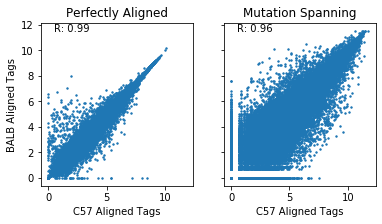

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(6,3),
                        sharex=True,
                        sharey=True)

axs[0].scatter(np.log2(mat.loc[:, mat.columns.str.contains('tag_perfect.*mm10')].mean(1)+1),
               np.log2(mat.loc[:, mat.columns.str.contains('tag_perfect.*balbcj')].mean(1)+1),
               s=2,
               rasterized=True)

axs[0].text(0.5,11.5, 'R: %.2f' % pearsonr(
    np.log2(mat.loc[:, mat.columns.str.contains('tag_perfect.*mm10')].mean(1)+1),
    np.log2(mat.loc[:, mat.columns.str.contains('tag_perfect.*balbcj')].mean(1)+1))[0],
    fontsize=10)

axs[0].set_xlabel('C57 Aligned Tags')
axs[0].set_ylabel('BALB Aligned Tags')
axs[0].set_title('Perfectly Aligned')

axs[1].scatter(np.log2(mat.loc[:, mat.columns.str.contains('tag_only.*mm10')].mean(1)+1),
               np.log2(mat.loc[:, mat.columns.str.contains('tag_only.*balbcj')].mean(1)+1),
               s=2,
               rasterized=True)

axs[1].text(0.5,11.5, 'R: %.2f' % pearsonr(
    np.log2(mat.loc[:, mat.columns.str.contains('tag_only.*mm10')].mean(1)+1),
    np.log2(mat.loc[:, mat.columns.str.contains('tag_only.*balbcj')].mean(1)+1))[0],
    fontsize=10)

axs[1].set_xlabel('C57 Aligned Tags')
# axs[1].set_ylabel('BALB Aligned Tags')
axs[1].set_title('Mutation Spanning')

plt.savefig('./figures/perfect_vs_mutation_scatter_comparison.pdf',
            bbox_inches='tight')